In [1]:
!python --version

Python 3.8.6


In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np

In [3]:
def tick_fir_filter(x, coefficients, inputs):
    next_inputs = np.concatenate([jnp.array([x]), inputs[0:-1]])
    y = 0.0
    for k in range(coefficients.size):
        y += coefficients[k] * next_inputs[k]
    return y, next_inputs

In [4]:
# Fills Y in-place
def fir_filter(X, Y, coefficients):
    inputs = np.zeros(coefficients.size)
    for i, x in enumerate(X):
        y, inputs = tick_fir_filter(x, coefficients, inputs)
        Y = Y.at[i].set(y) # Y[i] = y
    return Y

In [5]:
def tick_iir_filter(x, B, A, inputs, outputs):
    outputs[0] = 0.0
    inputs[0] = in_sample
    for i in range(inputs.size - 1, 0, -1):
        if i < B.size:
            outputs[0] += B[i] * inputs[i]
        inputs[i] = inputs[i-1]

    outputs[0] += B[0] * inputs[0]

    for i in range(A.size - 1, 0, -1):
        outputs[0] += -A[i] * outputs[i]
        outputs[i] = outputs[i-1]

    return outputs[0], inputs, outputs

In [6]:
# Fills Y in-place
def iir_filter(X, Y, B, A):
    inputs = np.zeros(B.size)
    outputs = np.zeros(B.size)
    for i, x in enumerate(X):
        y, inputs, outputs = tick_iir_filter(x, B, A, inputs, outputs)
        Y = Y.at[i].set(y) # Y[i] = y
    return Y

In [7]:
def mse(X, Y):
    return ((Y - X) ** 2).mean()

In [8]:
def train(params, objective, X, target, learning_rate=0.35, epochs=100):
    params_history = np.ndarray((epochs, params.size))
    Y = jnp.zeros(X.size)

    for epoch in range(epochs):
        gradient = grad(objective)(params, X, Y, target)
        params_history[epoch, :] = params
        params += learning_rate * gradient

    return params, params_history

In [9]:
def objective_fir(coefficients, X, Y, target):
    Y = fir_filter(X, Y, coefficients)
    return -mse(Y, target)

In [10]:
def objective_iir(B, A, X, Y, target):
    Y = iir_filter(X, Y, B, A)
    return -mse(Y, target)

In [11]:
X = jnp.concatenate([jnp.array([1]), jnp.zeros(9)])
Y = jnp.zeros(X.size)
target_params = np.array([0.1, 0.7, 0.5, 0.6])
target = fir_filter(X, Y, target_params)
key = random.PRNGKey(42)
params = random.uniform(key, (target_params.size,))
epochs = 50

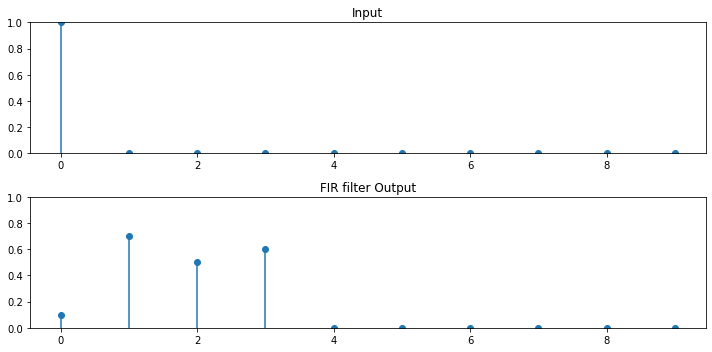

In [12]:
from matplotlib import pyplot as plt

X = jnp.concatenate([jnp.array([1]), jnp.zeros(9)])
Y = jnp.zeros(X.size)

_, (in_plot, out_plot) = plt.subplots(2, figsize=(10, 5))
in_plot.set_title('Input')
in_plot.stem(X, basefmt=' ')
in_plot.set_ylim([0, 1])
out_plot.set_title('FIR filter Output')
out_plot.stem(fir_filter(X, Y, target_params), basefmt=' ')
out_plot.set_ylim([0, 1])
plt.tight_layout()

In [13]:
%%time
params, params_history = train(params, objective_fir, X, target)

CPU times: user 20.7 s, sys: 2.67 s, total: 23.4 s
Wall time: 19.4 s


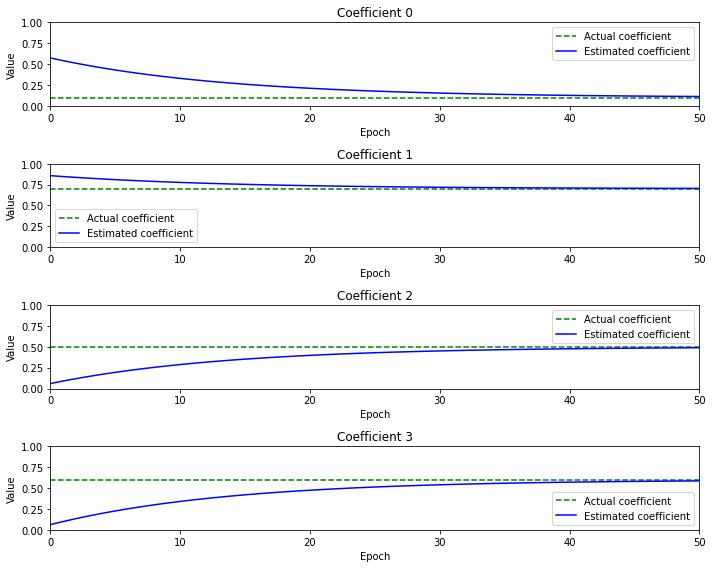

In [14]:
_, axes = plt.subplots(params.size, figsize=(10, params.size * 2))

for param_index in range(params.size):
    param_plot = axes[param_index]
    param_plot.set_title('Coefficient %s' % param_index)
    param_plot.set_xlim([0, epochs])
    param_plot.set_ylim([0, 1])
    param_plot.set_xlabel('Epoch')
    param_plot.set_ylabel('Value')
    param_plot.axhline(y=target_params[param_index], c='g', linestyle='--', label='Actual coefficient')
    param_plot.plot(params_history[:,param_index], c='b', label='Estimated coefficient')
    param_plot.legend()

plt.tight_layout()

In [15]:
class IirFilter:
    def __init__(self, b=[1.0], a=[1.0]):
        self.b = np.array(b)
        self.a = np.array(a)
        self.inputs = np.zeros(len(b))
        self.outputs = np.zeros(len(a))
        self.gain = 1.0

    def set_gain(self, gain):
        self.gain = gain

    def tick(self, in_sample):
        self.outputs[0] = 0.0
        self.inputs[0] = in_sample * self.gain
        for i in range(self.inputs.size - 1, 0, -1):
            if i < self.b.size: # See note in `set_b_coefficients`.
                self.outputs[0] += self.b[i] * self.inputs[i]
            self.inputs[i] = self.inputs[i-1]

        self.outputs[0] += self.b[0] * self.inputs[0]

        for i in range(self.a.size - 1, 0, -1):
            self.outputs[0] += -self.a[i] * self.outputs[i]
            self.outputs[i] = self.outputs[i-1]

        return self.outputs[0]

    def set_b_coefficients(self, b):
        # Allow growing and shrinking the b coefficients with minimal noise caused by 0s in history
        # by keeping inputs as the max length of any b coefficients that have been set.
        if len(b) > len(self.inputs):
            self.inputs = np.concatenate([self.inputs, np.zeros(len(b) - len(self.inputs))])
        self.b = np.array(b)

    # Convenience method wrapping around scipy.signal.freqz
    def freqz(self):
        return freqz(self.b, self.a)

In [16]:
# import IPython
# from scipy.io.wavfile import read as wavread

# wav_fs, X = wavread('speech-male.wav')
# X = X.astype(float) / X.max()
# print('Original sample:')
# IPython.display.Audio(X, rate=wav_fs)